In [53]:
import torchvision
import torch
from torch import nn, optim
import numpy as np
from torchtools.vq import VectorQuantize
import matplotlib.pyplot as plt

In [2]:
dataset = torchvision.datasets.MNIST('/mnist/', train=True, download=True, transform=torchvision.transforms.ToTensor())
loader = torch.utils.data.DataLoader(dataset, batch_size=16, shuffle=True)

dataset_val = torchvision.datasets.MNIST('/mnist/', train=False, download=True, transform=torchvision.transforms.ToTensor())
loader_val = torch.utils.data.DataLoader(dataset_val, batch_size=16)

In [63]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Linear') != -1:
        try:
            nn.init.xavier_uniform_(m.weight.data)
            m.bias.data.fill_(0)
        except AttributeError:
            print("Skipping initialization of ", classname)

In [64]:
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()       
        self.classifier = nn.Sequential(
            nn.Linear(784, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 10),
        )
        
        self.apply(weights_init)
                
    def forward(self, x):
        x = self.classifier(x)
        return x

mlp = MLP()
mlp.cuda()

MLP(
  (classifier): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=10, bias=True)
  )
)

In [65]:
epochs = 10
optimizer = optim.Adam(mlp.parameters(), lr=0.01)
criterion = nn.CrossEntropyLoss()
regular_losses = []
regular_accuracies = []
for e in range(1, epochs+1):
    for images, labels in loader:
        images, labels = images.cuda(), labels.cuda()
        pred = mlp.forward(images.view(-1, 784))        
        loss = criterion(pred, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    with torch.no_grad():
        val_loss = 0
        val_acc = 0
        for images, labels in loader_val:
            images, labels = images.cuda(), labels.cuda()
            pred = mlp.forward(images.view(-1, 784))        
            loss = criterion(pred, labels) 
            val_loss += loss.item()
            acc = (pred.argmax(dim=-1) == labels).float().mean()
            val_acc += acc.item()
    
    regular_losses.append(val_loss/len(loader_val))
    regular_accuracies.append(val_acc/len(loader_val))
    print(f"EPOCH {e} - loss {val_loss/len(loader_val)} - acc {val_acc/len(loader_val)}")

EPOCH 1 - loss 0.2115401767849922 - acc 0.9441
EPOCH 2 - loss 0.20457992555499077 - acc 0.9502
EPOCH 3 - loss 0.215694216299057 - acc 0.9417
EPOCH 4 - loss 0.23204572867155074 - acc 0.9442
EPOCH 5 - loss 0.2175224419593811 - acc 0.956
EPOCH 6 - loss 0.22261276255846024 - acc 0.9554
EPOCH 7 - loss 0.2290907833099365 - acc 0.9533
EPOCH 8 - loss 0.25321964643001554 - acc 0.9489
EPOCH 9 - loss 0.25061676266789434 - acc 0.9481
EPOCH 10 - loss 0.2666659568250179 - acc 0.9418


In [126]:
class vqMLP(nn.Module):
    def __init__(self):
        super(vqMLP, self).__init__()
        
        self.embedding_size = 1
        
        self.l1 = nn.Sequential(
            nn.Linear(784, 512),
            nn.ReLU()
        )
        
        self.vq1 = VectorQuantize(self.embedding_size, 512, ema_loss=True)
        
        self.l2 = nn.Sequential(
            nn.Linear(512, 256),
            nn.ReLU()
        )
        
        self.vq2 = VectorQuantize(self.embedding_size, 256)
        
        self.l3 = nn.Linear(256, 10)
        
        self.apply(weights_init)
        
    def forward(self, x):
        x = self.l1(x).view(-1, 512 // self.embedding_size, self.embedding_size)
        x, (_, commit_loss1), _ = self.vq1(x)
        x = x.view(-1, 512)
        
        x = self.l2(x).view(-1, 256 // self.embedding_size, self.embedding_size)
        x, (_, commit_loss2), _ = self.vq2(x)
        x = x.view(-1, 256)
        
        x = self.l3(x)
        return x, (commit_loss1 + commit_loss2)

vqmlp = vqMLP()
vqmlp.cuda()

vqMLP(
  (l1): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
  )
  (vq1): VectorQuantize(
    (codebook): Embedding(512, 1)
  )
  (l2): Sequential(
    (0): Linear(in_features=512, out_features=256, bias=True)
    (1): ReLU()
  )
  (vq2): VectorQuantize(
    (codebook): Embedding(256, 1)
  )
  (l3): Linear(in_features=256, out_features=10, bias=True)
)

In [127]:
epochs = 10
optimizer = optim.Adam(vqmlp.parameters(), lr=0.01)
criterion = nn.CrossEntropyLoss()
vq_losses = []
vq_accuracies = []
for e in range(1, epochs+1):
    vqmlp.train()
    for images, labels in loader:
        images, labels = images.cuda(), labels.cuda()
        pred, commit_loss = vqmlp.forward(images.view(-1, 784))        
        loss = criterion(pred, labels) + commit_loss * 0.25
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    vqmlp.eval()
    with torch.no_grad():
        val_loss = 0
        val_acc = 0
        for images, labels in loader_val:
            images, labels = images.cuda(), labels.cuda()
            pred, commit_loss = vqmlp.forward(images.view(-1, 784)) 
            # for comparison purposes, let's keep the commit loss out of the equation
            loss = criterion(pred, labels) # + commit_loss * 0.25 
            val_loss += loss.item()
            acc = (pred.argmax(dim=-1) == labels).float().mean()
            val_acc += acc.item()
            
    vq_losses.append(val_loss/len(loader_val))
    vq_accuracies.append(val_acc/len(loader_val))
    print(f"EPOCH {e} - loss {val_loss/len(loader_val)} - acc {val_acc/len(loader_val)}")

EPOCH 1 - loss 0.32467074761390685 - acc 0.9537
EPOCH 2 - loss 0.11570840238332748 - acc 0.9747
EPOCH 3 - loss 0.08951938426494599 - acc 0.9776
EPOCH 4 - loss 0.08535076506137848 - acc 0.9767
EPOCH 5 - loss 0.07794239637851715 - acc 0.9778
EPOCH 6 - loss 0.07721007231473923 - acc 0.9791
EPOCH 7 - loss 0.0749548682332039 - acc 0.9796
EPOCH 8 - loss 0.07753048594594002 - acc 0.9779
EPOCH 9 - loss 0.06836795064210892 - acc 0.9811
EPOCH 10 - loss 0.07650874952077866 - acc 0.9786


In [130]:
# Let's compare the number of parameters:

mlp_param_count = sum([p.numel() for p in mlp.parameters()])
vqmlp_param_count = sum([p.numel() for p in vqmlp.parameters()])

print("MLP", mlp_param_count)
print("vqMLP", vqmlp_param_count)
print(f"vqMLP has {vqmlp_param_count-mlp_param_count} parameters more.")

MLP 535818
vqMLP 536586
vqMLP has 768 parameters more.


[0.2115401767849922, 0.20457992555499077, 0.215694216299057, 0.23204572867155074, 0.2175224419593811, 0.22261276255846024, 0.2290907833099365, 0.25321964643001554, 0.25061676266789434, 0.2666659568250179]


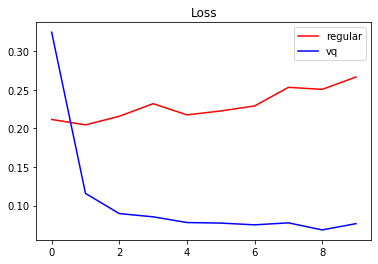

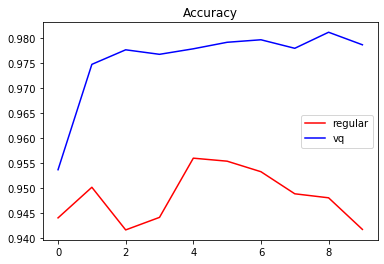

In [131]:
print(regular_losses)

plt.plot(regular_losses, marker='', color='red', label="regular")
plt.plot(vq_losses, marker='', color='blue', label="vq")
plt.legend()
plt.title('Loss')
plt.show()

plt.plot(regular_accuracies, marker='', color='red', label="regular")
plt.plot(vq_accuracies, marker='', color='blue', label="vq")
plt.legend()
plt.title('Accuracy')
plt.show()

In [ ]:
La linea roja es un MLP con 2 capas ocultas en MNIST: 
784 > 512 > 256 > 10 

La linea azul es el mismo MLP pero añadiendole vector quantization entre cada una de las capas ocultas

784 > 512 [quant] > 256 [quant] > 10 

Los parámetros de la cuantización son para la primera 512 y para la segunda 256 posibles valores únicos, es decir que solo añade al modelo 768 parámetros entrenables, cosa que no se nota casi (536330 vs 535818)

La quantización ralentiza un poco el modelo, eso sí, pero el efecto es sin duda flipante :O